In [192]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar-10/trainLabels.csv
/kaggle/input/cifar-10/sampleSubmission.csv
/kaggle/input/cifar-10/test.7z
/kaggle/input/cifar-10/train.7z


In [193]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tensorflow import keras
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Activation, BatchNormalization, Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

## Read the data from .ZIP form

In [194]:
os.getcwd()

'/kaggle/working'

In [195]:
!pip install py7zr

In [196]:
from py7zr import unpack_7zarchive
import shutil

#shutil.register_unpack_format('7zip',['.7z'],unpack_7zarchive)

In [197]:
shutil.unpack_archive('../input/cifar-10/train.7z', '/kaggle/temp/')

## Unziping the train data

In [198]:
train_labels = pd.read_csv("../input/cifar-10/trainLabels.csv", header="infer")

classes = train_labels['label'].unique()
print(classes)

['frog' 'truck' 'deer' 'automobile' 'bird' 'horse' 'ship' 'cat' 'dog'
 'airplane']


In [199]:
if not os.path.exists("/kaggle/temp/valid"):
    os.mkdir("/kaggle/temp/valid")
    
parent_path_train = "/kaggle/temp/train"
parent_path_valid = "/kaggle/temp/valid"
parent_path_test = "/kaggle/temp/test"

for class1 in classes:
    path_train = os.path.join(parent_path_train,class1)
    if not os.path.exists(path_train):
        os.mkdir(path_train)
    path_valid = os.path.join(parent_path_valid,class1)
    if not os.path.exists(path_valid):
        os.mkdir(path_valid)
        
for (int_ind,row) in train_labels.iterrows():
    id = str(row["id"])+".png"
    source_path = os.path.join(parent_path_train,id)
    
    p=np.random.random()
    if p<=0.8:
        target_path = os.path.join(parent_path_train,row["label"],id)
        os.replace(source_path, target_path)
    else:
        target_path = os.path.join(parent_path_valid,row["label"],id)
        os.replace(source_path, target_path)

In [200]:
!ls /kaggle/temp/valid
!ls /kaggle/temp/train

airplane  automobile  bird  cat  deer  dog  frog  horse  ship  truck
airplane  automobile  bird  cat  deer  dog  frog  horse  ship  truck


## Visualization training data from Keras Cifar10 for CNN

/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


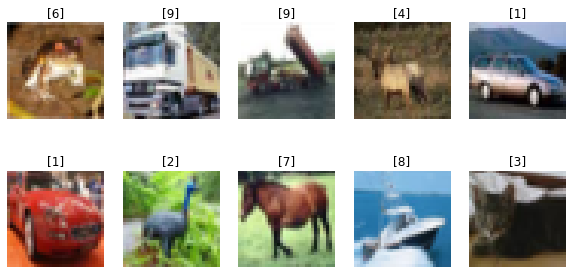

In [201]:
# Load the CIFAR-10 dataset
from keras.datasets import cifar10
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Plot the first 10 images from the training set
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()
for i in range(10):
    axes[i].imshow(x_train[i])
    axes[i].set_title(y_train[i])
    axes[i].axis('off')
plt.show()

In [202]:
x_train.shape

(50000, 32, 32, 3)

In [203]:
y_train.shape

(50000, 1)

## Train data preprocessing for CNN

In [204]:
y_train_categorical = tf.keras.utils.to_categorical(y_train, 10)
y_train_categorical[0]

x_train_reshaped = x_train.reshape(-1, 32, 32, 3)
x_train_reshaped.shape

(50000, 32, 32, 3)

In [205]:
y_train_categorical.sum(0)

array([5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.,
       5000.], dtype=float32)

In [206]:
x_train[0][:3,:3] #shape 28,28

array([[[59, 62, 63],
        [43, 46, 45],
        [50, 48, 43]],

       [[16, 20, 20],
        [ 0,  0,  0],
        [18,  8,  0]],

       [[25, 24, 21],
        [16,  7,  0],
        [49, 27,  8]]], dtype=uint8)

In [207]:
x_train_reshaped[0][:3,:3] #shape 28,28,1

array([[[59, 62, 63],
        [43, 46, 45],
        [50, 48, 43]],

       [[16, 20, 20],
        [ 0,  0,  0],
        [18,  8,  0]],

       [[25, 24, 21],
        [16,  7,  0],
        [49, 27,  8]]], dtype=uint8)

## Test data

In [208]:
y_test_categorical = tf.keras.utils.to_categorical(y_test, 10)
y_train_categorical[0]

x_test_reshaped = x_test.astype('float32')
x_test_reshaped.shape

(10000, 32, 32, 3)

## Model Training preprocessing for CNN

## First basic CNN made manually- model1

- with batchnorm, MaxPool, Flatten, Dense output 
- with augmentation score in Kaggle leaderboard 0.64 in competition

In [209]:
import numpy as np
import random as python_random

python_random.seed(123) #TOLE JE KOD, KTERÝ KDYŽ SPUSTÍM VÍCEKRÁT, VŽDY MÁM STEJNÉ VSTUPNÍ PODMÍNKY
np.random.seed(123)
tf.random.set_seed(1234)
import os
os.environ['PYTHONHASHSEED'] = '0' 


model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Conv2D(filters=4, kernel_size=(3,3), activation='relu', input_shape=(32,32,3) ) )
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

model1.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3)))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.ReLU())

model1.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3)))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.ReLU())

model1.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3)))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.ReLU())

model1.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

model1.add(tf.keras.layers.Flatten())
model1.add(tf.keras.layers.Dense(10, activation='softmax' ))

model1.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['acc'])   
model1.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_108 (Conv2D)          (None, 30, 30, 4)         112       
_________________________________________________________________
batch_normalization_105 (Bat (None, 30, 30, 4)         16        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 4)         0         
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 13, 13, 32)        1184      
_________________________________________________________________
batch_normalization_106 (Bat (None, 13, 13, 32)        128       
_________________________________________________________________
re_lu (ReLU)                 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 11, 11, 64)        1

In [210]:
model1.fit(x_train_reshaped, y_train_categorical, validation_data=(x_test_reshaped, y_test_categorical),batch_size=64, epochs=32)

Epoch 1/32
782/782 [==============================] - 6s 6ms/step - loss: 1.5909 - acc: 0.4403 - val_loss: 1.3278 - val_acc: 0.5219
Epoch 2/32
782/782 [==============================] - 4s 6ms/step - loss: 1.2192 - acc: 0.5697 - val_loss: 1.2716 - val_acc: 0.5520
Epoch 3/32
782/782 [==============================] - 4s 5ms/step - loss: 1.0646 - acc: 0.6272 - val_loss: 1.0872 - val_acc: 0.6184
Epoch 4/32
782/782 [==============================] - 4s 5ms/step - loss: 0.9565 - acc: 0.6675 - val_loss: 1.1723 - val_acc: 0.6003
Epoch 5/32
782/782 [==============================] - 4s 6ms/step - loss: 0.8703 - acc: 0.6981 - val_loss: 1.0322 - val_acc: 0.6409
Epoch 6/32
782/782 [==============================] - 4s 6ms/step - loss: 0.7994 - acc: 0.7228 - val_loss: 1.0510 - val_acc: 0.6405
Epoch 7/32
782/782 [==============================] - 5s 6ms/step - loss: 0.7313 - acc: 0.7448 - val_loss: 1.1231 - val_acc: 0.6269
Epoch 8/32
782/782 [==============================] - 4s 5ms/step - loss: 0.

## Second CNN with resiual joining manually (based on ResNet)- model2

- with residuals joining of layers, batchnorm, GlobalAveragePooling2D,  
- with augmentation score in Kaggle leaderboard 0.8459 in competition

In [211]:
import numpy as np
import random as python_random

python_random.seed(123) #TOLE JE KOD, KTERÝ KDYŽ SPUSTÍM VÍCEKRÁT, VŽDY MÁM STEJNÉ VSTUPNÍ PODMÍNKY
np.random.seed(123)
tf.random.set_seed(1234)
import os
os.environ['PYTHONHASHSEED'] = '0'

input_layer = tf.keras.layers.Input(shape=(32,32,3))
x = input_layer #na vstupu mám tyto fotky
x = tf.keras.layers.Normalization(mean=x_train_reshaped.mean(), variance=x_train_reshaped.var())(x) #FUNKCIONÁLNÍ API, 

filters_l = [32,64,128,128] #pole počtu filtrů, vykonám loop tolikrát s různým nastavením filtrů

#první konvoluce, na inicialzaci kernelu používám "he_unform", které jsou vhodné, 
x = tf.keras.layers.Conv2D(filters=filters_l[0], kernel_size=(3,3), kernel_initializer='he_uniform', activation='elu', padding='same')(x)
for i, filters in enumerate(filters_l): #postupně přes pole filters vytvářím vrstvy
    if i != len(filters_l)-1:
        downsample = True
    else:
        downsample = False
    
    res_con1 = x  
    x = tf.keras.layers.BatchNormalization()(x) #batch normalizace
    x = tf.keras.layers.ELU()(x)  #elu  poté konvoluce
    x = tf.keras.layers.Conv2D(filters=filters, kernel_size=(3,3), kernel_initializer='he_uniform', padding='same' )(x)
    x = tf.keras.layers.BatchNormalization()(x) 
    x = tf.keras.layers.ELU()(x) 
    x = tf.keras.layers.Conv2D(filters=filters, kernel_size=(3,3), kernel_initializer='he_uniform', padding='same' )(x)
    x = tf.keras.layers.Add()([res_con1,x]) #reziduální spojení
    
    res_con2 = x  
    x = tf.keras.layers.BatchNormalization()(x) 
    x = tf.keras.layers.ELU()(x) 
    x = tf.keras.layers.Conv2D(filters=filters, kernel_size=(3,3), kernel_initializer='he_uniform', padding='same' )(x)
    x = tf.keras.layers.BatchNormalization()(x) 
    x = tf.keras.layers.ELU()(x) 
    x = tf.keras.layers.Conv2D(filters=filters, kernel_size=(3,3), kernel_initializer='he_uniform', padding='same' )(x)
    x = tf.keras.layers.Add()([res_con1,res_con2,x])
    
    res_con3 = x  
    x = tf.keras.layers.BatchNormalization()(x) 
    x = tf.keras.layers.ELU()(x) 
    x = tf.keras.layers.Conv2D(filters=filters, kernel_size=(3,3), kernel_initializer='he_uniform', padding='same' )(x)
    x = tf.keras.layers.BatchNormalization()(x) 
    x = tf.keras.layers.ELU()(x) 
    x = tf.keras.layers.Conv2D(filters=filters, kernel_size=(3,3), kernel_initializer='he_uniform', padding='same' )(x)
    x = tf.keras.layers.Add()([res_con1,res_con2,res_con3,x])
    
    res_con = x
    if downsample: #downsampling, když stride je 2, což mi výstup 2xzmenší u convoluce, padding-same značí, že pokud není stride, tak výstup kovnoluce je stejný jako vstup
        res_con = tf.keras.layers.BatchNormalization()(res_con)
        res_con = tf.keras.layers.ELU()(res_con) 
        res_con = tf.keras.layers.Conv2D(filters=(filters if not downsample else filters_l[i+1]), kernel_size=(3,3), kernel_initializer='he_uniform', strides=2, padding='same' )(res_con)
        
     
    x = tf.keras.layers.BatchNormalization()(x) 
    x = tf.keras.layers.ELU()(x) 
    x = tf.keras.layers.Conv2D(filters=filters, kernel_size=(3,3), kernel_initializer='he_uniform', padding='same' )(x)
    x = tf.keras.layers.BatchNormalization()(x) 
    x = tf.keras.layers.ELU()(x) 
    x = tf.keras.layers.Conv2D(filters=(filters if not downsample else filters_l[i+1]), kernel_size=(3,3), kernel_initializer='he_uniform', strides=(2 if downsample else 1), padding='same' )(x)
    x = tf.keras.layers.Add()([res_con,x])
    
x = tf.keras.layers.GlobalAveragePooling2D()(x) #nakonci poslední vsvy neudělám MaxPooling, ale GlobalAveraooling, což zlepší přesnost!!
x = tf.keras.layers.Dense(10, activation='softmax')(x)
model2 = tf.keras.Model(input_layer, x)
model2.compile(optimizer=tf.keras.optimizers.Adam(0.001), #leraning rate pro 1 by se to ani netrénovalo, pro malé číslo zase strašně dlouho
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), metrics=['acc'])   #labelsmooting místo too, aby všechny labely, které byly 0 mi předělalo na 0.1 a labely 1 předělalo na 0.9 a to způsobí, že se to nebude tolikrát přetrénovávat

model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
normalization_22 (Normalization (None, 32, 32, 3)    0           input_23[0][0]                   
__________________________________________________________________________________________________
conv2d_112 (Conv2D)             (None, 32, 32, 32)   896         normalization_22[0][0]           
__________________________________________________________________________________________________
batch_normalization_109 (BatchN (None, 32, 32, 32)   128         conv2d_112[0][0]                 
____________________________________________________________________________________________

In [212]:
model2.fit(x_train_reshaped, y_train_categorical, validation_data=(x_test_reshaped, y_test_categorical),batch_size=64, epochs=32)

Epoch 1/32
782/782 [==============================] - 32s 36ms/step - loss: 1.9159 - acc: 0.4691 - val_loss: 1.4432 - val_acc: 0.6024
Epoch 2/32
782/782 [==============================] - 27s 35ms/step - loss: 1.2762 - acc: 0.6656 - val_loss: 1.2398 - val_acc: 0.6889
Epoch 3/32
782/782 [==============================] - 28s 36ms/step - loss: 1.1160 - acc: 0.7463 - val_loss: 1.1865 - val_acc: 0.7201
Epoch 4/32
782/782 [==============================] - 27s 34ms/step - loss: 1.0264 - acc: 0.7927 - val_loss: 1.0960 - val_acc: 0.7652
Epoch 5/32
782/782 [==============================] - 27s 34ms/step - loss: 0.9637 - acc: 0.8228 - val_loss: 1.1108 - val_acc: 0.7570
Epoch 6/32
782/782 [==============================] - 27s 35ms/step - loss: 0.9128 - acc: 0.8490 - val_loss: 1.0359 - val_acc: 0.7902
Epoch 7/32
782/782 [==============================] - 27s 35ms/step - loss: 0.8631 - acc: 0.8740 - val_loss: 1.0701 - val_acc: 0.7754
Epoch 8/32
782/782 [==============================] - 28s 35ms

## Third CNN with EfficientNetB0(Transfer Learning)- model3

- with pre-trained CNN called EfficientNetB0  
- with score in Kaggle leaderboard 0,6769 in competition

In [213]:
import numpy as np
import random as python_random

python_random.seed(123) #TOLE JE KOD, KTERÝ KDYŽ SPUSTÍM VÍCEKRÁT, VŽDY MÁM STEJNÉ VSTUPNÍ PODMÍNKY
np.random.seed(123)
tf.random.set_seed(1234)
import os
os.environ['PYTHONHASHSEED'] = '0'


model3 = tf.keras.applications.EfficientNetB0(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(32,32,3),
    pooling=None,
    classes=10,
    classifier_activation="softmax")
    
model3.summary()
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])


Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescaling_19 (Rescaling)        (None, 32, 32, 3)    0           input_24[0][0]                   
__________________________________________________________________________________________________
normalization_23 (Normalization (None, 32, 32, 3)    7           rescaling_19[0][0]               
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 33, 33, 3)    0           normalization_23[0][0]           
_____________________________________________________________________________________

## Training the CNN model

In [214]:
model3.fit(x_train_reshaped, y_train_categorical, validation_data=(x_test_reshaped, y_test_categorical),batch_size=64, epochs=32)

Epoch 1/32
782/782 [==============================] - 45s 48ms/step - loss: 2.7793 - acc: 0.1881 - val_loss: 2.0890 - val_acc: 0.2226
Epoch 2/32
782/782 [==============================] - 37s 48ms/step - loss: 2.3751 - acc: 0.2550 - val_loss: 2.0472 - val_acc: 0.2865
Epoch 3/32
782/782 [==============================] - 39s 50ms/step - loss: 2.2819 - acc: 0.2911 - val_loss: 2.1115 - val_acc: 0.2984
Epoch 4/32
782/782 [==============================] - 40s 51ms/step - loss: 2.2077 - acc: 0.3001 - val_loss: 7.9620 - val_acc: 0.2700
Epoch 5/32
782/782 [==============================] - 39s 50ms/step - loss: 2.2417 - acc: 0.2801 - val_loss: 2.3927 - val_acc: 0.2744
Epoch 6/32
782/782 [==============================] - 39s 50ms/step - loss: 2.1416 - acc: 0.3096 - val_loss: 2.0303 - val_acc: 0.3677
Epoch 7/32
782/782 [==============================] - 39s 50ms/step - loss: 2.0374 - acc: 0.3404 - val_loss: 2.1297 - val_acc: 0.3206
Epoch 8/32
782/782 [==============================] - 38s 49ms

## Augmentation of the CNN

In [215]:
train_datagen = ImageDataGenerator(featurewise_center=False,
                             samplewise_center=False,
                             featurewise_std_normalization=False,
                             samplewise_std_normalization=False,
                             zca_whitening=False,
                             rotation_range=10,
                             zoom_range=0.1,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=False,
                             vertical_flip=False,
                             rescale=1./255)
valid_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(directory='/kaggle/temp/train/', shuffle=True, target_size=(32,32),batch_size=128)
valid_generator = valid_datagen.flow_from_directory(directory='/kaggle/temp/valid/', shuffle=True, target_size=(32,32),batch_size=128)

Found 49930 images belonging to 10 classes.
Found 29590 images belonging to 10 classes.


In [216]:
model1.save('my_model1')
model2.save('my_model2')
model3.save('my_model3')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Unzipping Test Data

In [218]:
shutil.unpack_archive('/kaggle/input/cifar-10/test.7z','/kaggle/temp/test')

In [219]:
shutil.unpack_archive('../input/cifar-10/train.7z', '/kaggle/temp/')

In [220]:
test_datagen = ImageDataGenerator(rescale=1./1.)

test_gen = test_datagen.flow_from_directory(directory='/kaggle/temp/test',target_size=(32,32),batch_size=64,class_mode=None,shuffle=False)

Found 300000 images belonging to 1 classes.


In [221]:
test_gen.reset()
predictions_vecs1 = model1.predict(test_gen)
predictions_vecs2 = model2.predict(test_gen)
#predictions_vecs3 = model3.predict(test_gen)

predictions_final = np.argmax(predictions_vecs2, axis=1)

## Create labels for classes for submission

In [222]:
print(type(train_generator.class_indices))
print(train_generator.class_indices)

classes = {value:key for (key,value) in train_generator.class_indices.items()}
print(classes)

predicted_classes=np.empty(shape=300000,dtype=np.dtype('U20'))

ind=0
for i in predictions_final.tolist():
    predicted_classes[ind]=classes[i]
    ind=ind+1
    
filenames_wo_ext = []
for fname in test_gen.filenames:
    filenames_wo_ext.append(int(fname.split(sep="/")[1].split(sep=".")[0])-1)

predicted_classes_final = np.empty(shape=300000,dtype=np.dtype('U20'))
predicted_classes_final[filenames_wo_ext]=predicted_classes

<class 'dict'>
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


## Prediction

In [223]:
model1.predict(x_train_reshaped[:2])
model2.predict(x_train_reshaped[:2])
model3.predict(x_train_reshaped[:2])

array([[7.2770310e-04, 1.3595736e-03, 8.7979205e-02, 1.2971501e-01,
        3.1666275e-02, 1.1259307e-01, 6.2628663e-01, 7.6721762e-03,
        4.4215846e-04, 1.5581689e-03],
       [4.7905222e-03, 9.5237615e-03, 2.7969461e-03, 3.0689791e-04,
        1.2736376e-04, 1.9137553e-04, 9.0063186e-05, 9.7454467e-04,
        2.4214212e-03, 9.7877711e-01]], dtype=float32)

## Submission

In [224]:
sub = pd.read_csv('../input/cifar-10/sampleSubmission.csv',header='infer')
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      300000 non-null  int64 
 1   label   300000 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.6+ MB


In [225]:
sub['label'] = predicted_classes_final
sub.to_csv('submission.csv',index=False)

In [226]:
sub

,id,label
0,1,airplane
1,2,airplane
2,3,automobile
3,4,ship
4,5,bird
...,...,...
299995,299996,ship
299996,299997,frog
299997,299998,deer
299998,299999,frog
